**Kwaku Amo-Korankye - 10211100331<br>Class of 2025: Bachelor of Science in Artificial Intelligence<br>AI4226: Intermediate Deep Learning<br>Multiclass Classification Model Evaluation**

Dependency Installation

In [8]:
import torch
import cv2
import os
from PIL import Image
import numpy as np
import matplotlib.pyplot as plt
from torchvision import transforms
import shap
import time
from skimage.metrics import structural_similarity as ssim

Model Loading and Class Definition

In [9]:
# Define class labels
classes = ['pituitary', 'bone fractured', 'healthy brain', 'adenocarcinoma', 'glioma', 'benign', 'breast cancer positive', 'bone not fractured', 'squamous cell carcinoma', 'meningioma', 'breast cancer negative']

# Define image transformations (same as validation set)
transform = transforms.Compose([
        transforms.Resize((224, 224)),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.5], std=[0.5])
    ])


# Load the trained model
comprehensive_model = torch.load("/Users/academiccity/Documents/amokorankye/front end/server/comprehensive_model.pth", weights_only=False )
comprehensive_model.eval()  # Set to evaluation mode

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

Model Evaluation

In [15]:
def evaluate_classification_model(model=comprehensive_model, test_dir=None, batch_size=32):
    """
    Evaluate the classification model using standard metrics:
    - Accuracy
    - Precision, Recall, F1-score
    - Confusion Matrix
    - ROC AUC (for multi-class, we'll use one-vs-rest)
    """
    from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, roc_auc_score, roc_curve
    from torch.utils.data import DataLoader, Dataset
    import seaborn as sns
    from tqdm.notebook import tqdm
    
    class TestDataset(Dataset):
        """Custom dataset to load test images from directory"""
        def __init__(self, test_dir, transform=transform):
            self.test_dir = test_dir
            self.transform = transform
            self.image_paths = []
            self.labels = []
            
            # Example structure: test_dir/class_name/image.jpg
            for class_idx, class_name in enumerate(classes):
                class_dir = os.path.join(test_dir, class_name)
                if os.path.isdir(class_dir):
                    for img_name in os.listdir(class_dir):
                        if img_name.lower().endswith(('.jpg', '.jpeg', '.png', '.bmp', '.tiff')):
                            self.image_paths.append(os.path.join(class_dir, img_name))
                            self.labels.append(class_idx)
            
        def __len__(self):
            return len(self.image_paths)
        
        def __getitem__(self, idx):
            image_path = self.image_paths[idx]
            label = self.labels[idx]
            
            # Load and transform image
            image = Image.open(image_path)
            if image.mode != 'RGB':
                image = image.convert('RGB')
            
            if self.transform:
                image = self.transform(image)
                
            return image, label
    
    # If no test directory is provided, show a message
    if test_dir is None:
        print("Please provide a test_dir path to evaluate the model on a test dataset.")
        print("Skipping evaluation metrics that require a test dataset.")
        return
    
    # Initialize test dataset and dataloader
    test_dataset = TestDataset(test_dir)
    test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)
    
    # Set model to evaluation mode
    model.eval()
    
    # Lists to store predictions and true labels
    all_preds = []
    all_labels = []
    all_probs = []
    
    # Perform inference
    with torch.no_grad():
        for images, labels in tqdm(test_loader, desc="Evaluating model"):
            # Move data to the same device as model
            device = next(model.parameters()).device
            images = images.to(device)
            
            # Forward pass
            outputs = model(images)
            probs = torch.nn.functional.softmax(outputs, dim=1)
            preds = torch.argmax(outputs, dim=1)
            
            # Store results
            all_preds.extend(preds.cpu().numpy())
            all_labels.extend(labels.numpy())
            all_probs.extend(probs.cpu().numpy())
    
    # Convert to numpy arrays for easier handling
    all_preds = np.array(all_preds)
    all_labels = np.array(all_labels)
    all_probs = np.array(all_probs)
    
    # Calculate metrics
    accuracy = accuracy_score(all_labels, all_preds)
    
    # Print classification report
    print("\n=== Classification Report ===")
    print(classification_report(all_labels, all_preds, target_names=classes))
    
    # Calculate confusion matrix
    cm = confusion_matrix(all_labels, all_preds)
    
    # Plot confusion matrix
    plt.figure(figsize=(12, 10))
    sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=classes, yticklabels=classes)
    plt.title("Confusion Matrix")
    plt.xlabel("Predicted Label")
    plt.ylabel("True Label")
    plt.xticks(rotation=45, ha="right")
    plt.tight_layout()
    plt.show()
    
    # Calculate ROC AUC (one vs rest for multi-class)
    try:
        # One-hot encode the labels for ROC AUC calculation
        roc_auc = roc_auc_score(
            np.eye(len(classes))[all_labels],  # Convert to one-hot encoding
            all_probs,
            multi_class='ovr'
        )
        print(f"\nROC AUC Score (One-vs-Rest): {roc_auc:.4f}")
        
        # Plot ROC curves for each class
        plt.figure(figsize=(12, 8))
        for i, class_name in enumerate(classes):
            y_true = (all_labels == i).astype(int)
            y_score = all_probs[:, i]
            
            fpr, tpr, _ = roc_curve(y_true, y_score)
            plt.plot(fpr, tpr, label=f"{class_name} (AUC: {roc_auc_score(y_true, y_score):.4f})")
        
        plt.plot([0, 1], [0, 1], 'k--')  # Diagonal line
        plt.xlabel('False Positive Rate')
        plt.ylabel('True Positive Rate')
        plt.title('ROC Curves (One-vs-Rest)')
        plt.legend(loc="lower right")
        plt.show()
    except Exception as e:
        print(f"Error calculating ROC AUC: {e}")

    # Print summary metrics
    print("\n=== Summary Metrics ===")
    print(f"Accuracy: {accuracy:.4f}")
    
    return {
        "accuracy": accuracy,
        "predictions": all_preds,
        "true_labels": all_labels,
        "probabilities": all_probs
    }

Model Evaluation


=== Running Image-by-Image Model Evaluation ===


Evaluating model:   0%|          | 0/281 [00:00<?, ?it/s]


=== Classification Report ===
                         precision    recall  f1-score   support

              pituitary       0.99      1.00      0.99       265
         bone fractured       1.00      1.00      1.00       343
          healthy brain       1.00      1.00      1.00       300
         adenocarcinoma       1.00      1.00      1.00       750
                 glioma       1.00      0.99      1.00       244
                 benign       1.00      1.00      1.00       750
 breast cancer positive       0.87      0.85      0.86       175
     bone not fractured       1.00      1.00      1.00       334
squamous cell carcinoma       1.00      1.00      1.00       750
             meningioma       1.00      0.99      0.99       248
 breast cancer negative       0.92      0.93      0.93       335

               accuracy                           0.99      4494
              macro avg       0.98      0.98      0.98      4494
           weighted avg       0.99      0.99      0.99   

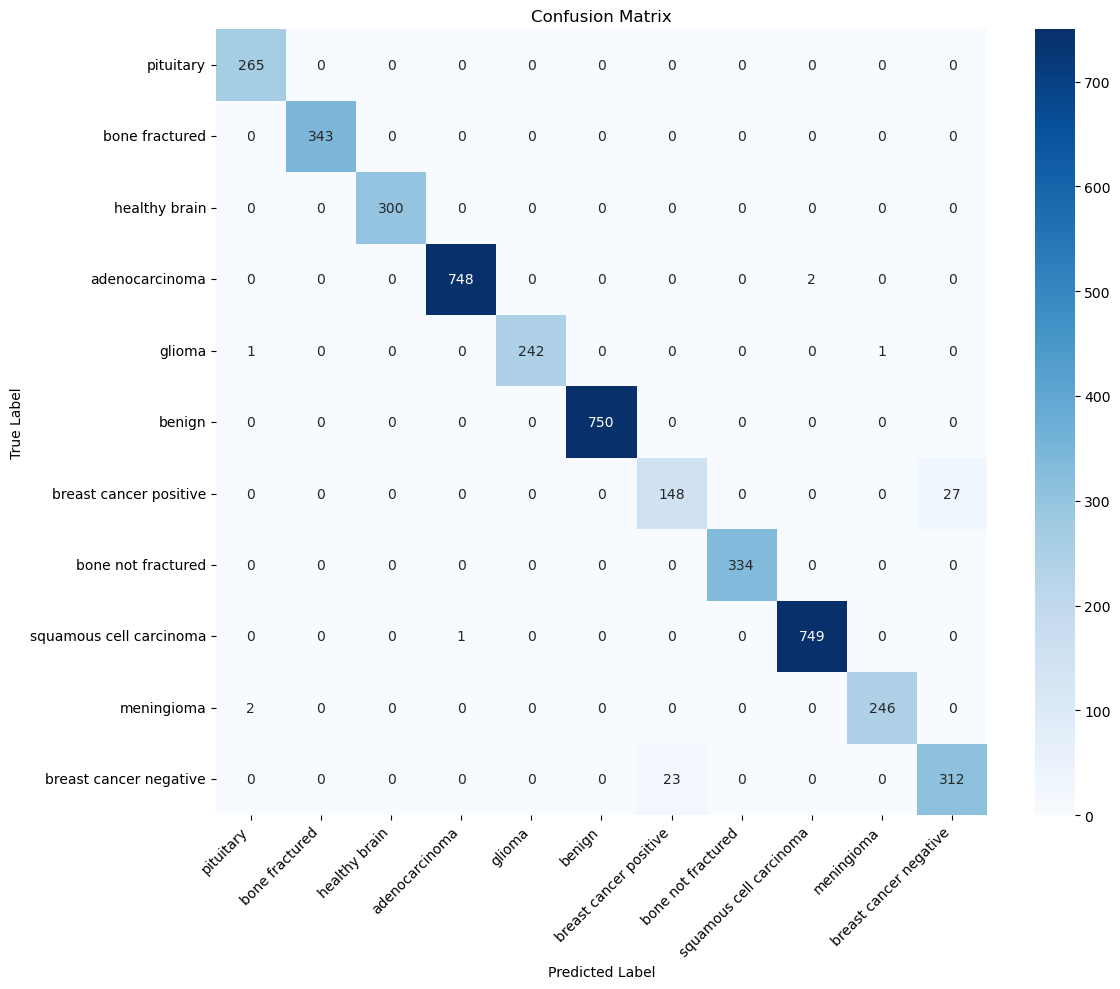


ROC AUC Score (One-vs-Rest): 0.9994


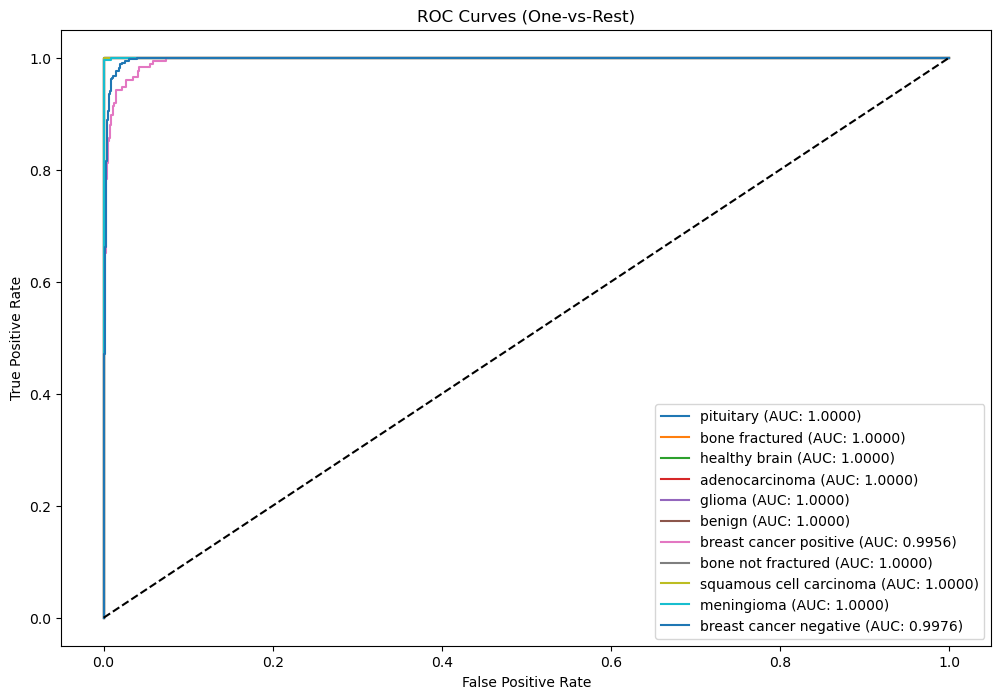


=== Summary Metrics ===
Accuracy: 0.9873
Overall model accuracy on test set: 0.9873
Found 4494 images in the test directory


Processing images:   0%|          | 0/4494 [00:00<?, ?it/s]


Diagnosis Results:
Classification: pituitary
Confidence: 100.00%

Class Probabilities:
pituitary: 100.00%
healthy brain: 0.00%
glioma: 0.00%
meningioma: 0.00%

Diagnosis Results:
Classification: pituitary
Confidence: 100.00%

Class Probabilities:
pituitary: 100.00%
healthy brain: 0.00%
glioma: 0.00%
meningioma: 0.00%

Diagnosis Results:
Classification: pituitary
Confidence: 100.00%

Class Probabilities:
pituitary: 100.00%
healthy brain: 0.00%
glioma: 0.00%
meningioma: 0.00%

Diagnosis Results:
Classification: pituitary
Confidence: 100.00%

Class Probabilities:
pituitary: 100.00%
healthy brain: 0.00%
glioma: 0.00%
meningioma: 0.00%

Diagnosis Results:
Classification: pituitary
Confidence: 100.00%

Class Probabilities:
pituitary: 100.00%
healthy brain: 0.00%
glioma: 0.00%
meningioma: 0.00%

Diagnosis Results:
Classification: pituitary
Confidence: 100.00%

Class Probabilities:
pituitary: 100.00%
healthy brain: 0.00%
glioma: 0.00%
meningioma: 0.00%

Diagnosis Results:
Classification: pitu

,Image,Path,True Class,Predicted Class,Confidence,Diagnosis Area,Prob_pituitary,Prob_healthy brain,Prob_glioma,Prob_meningioma,Prob_bone fractured,Prob_bone not fractured,Prob_adenocarcinoma,Prob_benign,Prob_squamous cell carcinoma,Prob_breast cancer negative,Prob_breast cancer positive
0,0717.jpg,/Users/academiccity/Documents/amokorankye/fina...,pituitary,pituitary,1.000000,Brain Tumors,1.000000,3.051753e-13,3.210387e-11,2.541284e-10,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,0924.jpg,/Users/academiccity/Documents/amokorankye/fina...,pituitary,pituitary,1.000000,Brain Tumors,1.000000,6.508251e-13,4.508790e-12,1.107911e-11,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,1384.jpg,/Users/academiccity/Documents/amokorankye/fina...,pituitary,pituitary,1.000000,Brain Tumors,1.000000,3.072254e-12,5.104745e-08,4.791177e-08,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,0515.jpg,/Users/academiccity/Documents/amokorankye/fina...,pituitary,pituitary,1.000000,Brain Tumors,1.000000,1.526983e-15,4.078049e-11,4.065910e-11,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,0273.jpg,/Users/academiccity/Documents/amokorankye/fina...,pituitary,pituitary,0.999955,Brain Tumors,0.999955,4.347106e-10,4.518679e-05,2.495222e-08,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4489,2460_1258092255_png.rf.e59e6081399a9dccaa460e3...,/Users/academiccity/Documents/amokorankye/fina...,breast cancer negative,breast cancer negative,0.998992,Breast Cancer,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.998992,0.000934
4490,397_1789866598_png.rf.40cfbab4891d9e9f784d340c...,/Users/academiccity/Documents/amokorankye/fina...,breast cancer negative,breast cancer negative,0.972609,Breast Cancer,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.972609,0.027351
4491,2003_1464197046_png.rf.0faeeb827c16f04e7b4a80d...,/Users/academiccity/Documents/amokorankye/fina...,breast cancer negative,breast cancer negative,0.940605,Breast Cancer,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.940605,0.059378
4492,2526_1760302830_png.rf.24bfe2212ac96bb3ebaf3ab...,/Users/academiccity/Documents/amokorankye/fina...,breast cancer negative,breast cancer negative,0.906494,Breast Cancer,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.906494,0.093324


In [19]:
import os
from tqdm.notebook import tqdm
import pandas as pd

# Model Evaluation - Individual Image Processing
print("\n=== Running Image-by-Image Model Evaluation ===")

# Path to test dataset 
test_data_dir = "/Users/academiccity/Documents/amokorankye/final models/dataset/test"

# First run standard evaluation if the test directory has class subdirectories
if os.path.exists(test_data_dir):
    try:
        # Standard evaluation - treats the directory structure as test_dir/class_name/images.jpg
        eval_results = evaluate_classification_model(
            model=comprehensive_model, 
            test_dir=test_data_dir, 
            batch_size=16
        )
        
        if eval_results:
            accuracy = eval_results["accuracy"]
            print(f"Overall model accuracy on test set: {accuracy:.4f}")
    except Exception as e:
        print(f"Standard evaluation failed: {str(e)}")
        print("Proceeding with individual image evaluation...")

# Now let's iterate through all images in the test directory, regardless of structure

# Initialize lists to store results
all_images = []
image_classes = {}  # Map from image path to class (if determinable from directory structure)

# Function to recursively find all image files
def find_all_images(directory):
    images = []
    for root, _, files in os.walk(directory):
        for file in files:
            if file.lower().endswith(('.jpg', '.jpeg', '.png', '.bmp', '.tiff')):
                full_path = os.path.join(root, file)
                images.append(full_path)
                
                # Try to determine class from directory structure
                parent_dir = os.path.basename(os.path.dirname(full_path))
                if parent_dir in classes:
                    image_classes[full_path] = parent_dir
                    
    return images

# Get all image files
all_images = find_all_images(test_data_dir)
print(f"Found {len(all_images)} images in the test directory")

# Process each image
results = []

for img_path in tqdm(all_images, desc="Processing images"):
    # Try to determine true class from directory structure
    true_class = image_classes.get(img_path, None)
    
    # Determine diagnosis area based on file name or directory
    filename = os.path.basename(img_path).lower()
    parent_dir = os.path.basename(os.path.dirname(img_path)).lower()
    
    if any(x in filename for x in ['glioma', 'meningioma', 'pituitary']) or any(x in parent_dir for x in ['glioma', 'meningioma', 'pituitary', 'brain']):
        diagnosisArea = "Brain Tumors"
    elif any(x in filename for x in ['breast']) or 'breast' in parent_dir:
        diagnosisArea = "Breast Cancer"
    elif any(x in filename for x in ['bone', 'fracture']) or any(x in parent_dir for x in ['bone', 'fracture']):
        diagnosisArea = "Bone Fractures"
    elif any(x in filename for x in ['adenocarcinoma', 'squamous', 'benign', 'lung']) or any(x in parent_dir for x in ['adenocarcinoma', 'squamous', 'benign', 'lung']):
        diagnosisArea = "Lung Cancer"
    else:
        # If no specific diagnosis area can be determined, use None
        diagnosisArea = None
    
    # Run prediction
    try:
        pred_result = predict(img_path, diagnosisArea)
        if pred_result:
            result = {
                'Image': os.path.basename(img_path),
                'Path': img_path,
                'True Class': true_class,
                'Predicted Class': pred_result['diagnosis'],
                'Confidence': pred_result['confidence'],
                'Diagnosis Area': diagnosisArea
            }
            
            # Add detailed probabilities
            for cls, prob in pred_result.get('probabilities', {}).items():
                result[f'Prob_{cls}'] = prob
                
            results.append(result)
    except Exception as e:
        print(f"Error processing {img_path}: {str(e)}")
    
# Create DataFrame from results
results_df = pd.DataFrame(results)

# Display summary statistics
if len(results_df) > 0:
    print("\n=== Image Evaluation Summary ===")
    print(f"Total images processed: {len(results_df)}")
    print(f"Average prediction confidence: {results_df['Confidence'].mean():.4f}")
    
    # Check accuracy if true classes are available
    if 'True Class' in results_df.columns and not results_df['True Class'].isna().all():
        correct = (results_df['True Class'] == results_df['Predicted Class']).sum()
        total = results_df['True Class'].notna().sum()
        accuracy = correct / total if total > 0 else float('nan')
        print(f"Accuracy on labeled images: {accuracy:.4f} ({correct}/{total})")
    
    # Group by diagnosis area
    if 'Diagnosis Area' in results_df.columns:
        print("\n=== Results by Diagnosis Area ===")
        area_counts = results_df['Diagnosis Area'].value_counts()
        for area, count in area_counts.items():
            area_df = results_df[results_df['Diagnosis Area'] == area]
            print(f"{area}: {count} images, Avg. Confidence = {area_df['Confidence'].mean():.4f}")
    
    # Save full results dataframe for further analysis
    image_evaluation_results = results_df
    display(results_df)
else:
    print("No results were generated. Check for errors in the processing.")